## Panorama Stitching using SuperGlue
SuperGlue network is a Graph Neural Network combined with an Optimal Matching layer that is trained to perform matching on two sets of sparse image features.

**This project is heavily inspired by: [Stitch-images-using-SuperGlue-GNN](https://github.com/bimalka98/Stitch-images-using-SuperGlue-GNN.git)**

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import onnxruntime as ort
import os

img_name = "out"

In [8]:

# if lightglue onnx model doesnt exists then export it
if not os.path.exists("lightglue.onnx"):
    !cd ../LightGlue-ONNX && python3.8 export.py --end2end --dynamic --max_num_keypoints 1024 --lightglue_path ../python/lightglue.onnx

In [21]:
def pltSourceImages(point_set1, point_set2):    
    im_left = cv.imread('imgs/{img}-01.jpg'.format(img=img_name),cv.IMREAD_ANYCOLOR)
    im_right = cv.imread('imgs/{img}-00.jpg'.format(img=img_name),cv.IMREAD_ANYCOLOR)
    im_left = cv.cvtColor(im_left, cv.COLOR_BGR2RGB)
    im_right = cv.cvtColor(im_right, cv.COLOR_BGR2RGB)
    if im_left is None or im_right is None:
        print('Could not open or find the images!')
    
    # Marking the detected features on the two images.
    for point in point_set1.astype(np.int32):
        cv.circle(im_left, tuple(point), radius=4, color=(255, 255, 0), thickness=-1)

    for point in point_set2.astype(np.int32):
        cv.circle(im_right, tuple(point), radius=4, color=(255, 255, 0), thickness=-1)

    fig = plt.figure(figsize = (10,10))
    plt.subplot(121),plt.imshow(im_left)
    plt.subplot(122),plt.imshow(im_right)
    plt.show()

In [22]:
def plotMatches(imageSet):
    plt.figure(figsize=(10,10))
    matched_points = cv.imread('panorama/output/{img}-{:02}_{img}-{:02}_matches.png'.format(imageSet, imageSet -1, img=img_name),cv.IMREAD_ANYCOLOR)
    if matched_points is None:
        print('Could not open or find the images!')
    plt.imshow(matched_points, cmap='gray', vmin = 0, vmax = 255)
    plt.show()

Get result from OpenCV Stitching module to compare

In [23]:
im_left = cv.imread(f'imgs/{img_name}-00.jpg',cv.IMREAD_ANYCOLOR)
im_right = cv.imread(f'imgs/{img_name}-01.jpg',cv.IMREAD_ANYCOLOR)    
im_left = cv.cvtColor(im_left, cv.COLOR_BGR2RGB)
im_right = cv.cvtColor(im_right, cv.COLOR_BGR2RGB)


stitcher = cv.Stitcher.create(cv.Stitcher_PANORAMA)
status, stitched = stitcher.stitch([im_left, im_right])



plt.imshow(im_left, cmap='gray', vmin = 0, vmax = 255)
plt.show()
plt.imshow(im_right, cmap='gray', vmin = 0, vmax = 255)
plt.show()
if status == cv.Stitcher_OK:
    plt.imshow(stitched, cmap='gray', vmin = 0, vmax = 255)
    plt.show()
else:
     print("Can't stitch images, error code = %d" % status)

error: OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


2024-04-08 10:07:04.641395015 [W:onnxruntime:, graph.cc:3593 CleanUnusedInitializersAndNodeArgs] Removing initializer '734'. It is not used by any node and should be removed from the model.
2024-04-08 10:07:04.641453715 [W:onnxruntime:, graph.cc:3593 CleanUnusedInitializersAndNodeArgs] Removing initializer '1275'. It is not used by any node and should be removed from the model.


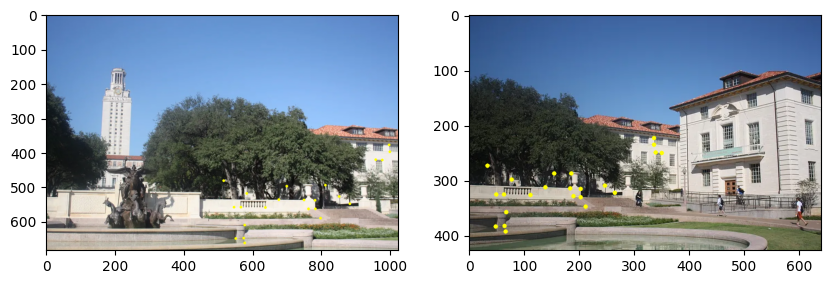

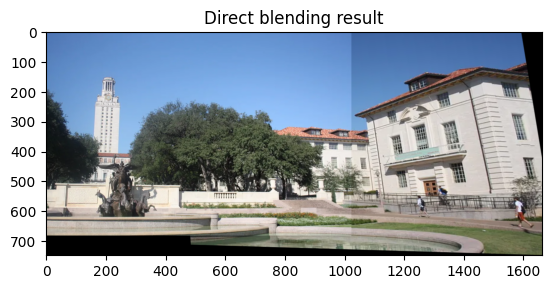

True

In [ ]:

# getting the required source images
im_left = cv.imread('imgs/{img}-01.jpg'.format(img=img_name))
im_right = cv.imread('imgs/{img}-00.jpg'.format(img=img_name))

im_left_gr =  cv.cvtColor(im_left, cv.COLOR_BGR2GRAY)
im_right_gr = cv.cvtColor(im_right, cv.COLOR_BGR2GRAY)


im_left_gr = im_left_gr.astype('float32') / 255.0
im_right_gr = im_right_gr.astype('float32') / 255.0

im_right_tensor =  im_right_gr[np.newaxis, np.newaxis, :, :]
im_left_tensor =  im_left_gr[np.newaxis, np.newaxis, :, :]

im_left = cv.cvtColor(im_left, cv.COLOR_BGR2RGB)
im_right = cv.cvtColor(im_right, cv.COLOR_BGR2RGB)


ort_sess = ort.InferenceSession('../LightGlue-ONNX/lightglue.onnx')
outputs = ort_sess.run(None, {"image0": im_right_tensor, "image1":im_left_tensor})

kpts0 = outputs[0]
kpts1 = outputs[1]
matches0 = outputs[2]

# Gather the matching keypoints
matched_kpts0 = kpts0[0][matches0[:, 0]]
matched_kpts1 = kpts1[0][matches0[:, 1]]

pltSourceImages(point_set1=matched_kpts1, point_set2=matched_kpts0)


homography, _ = cv.findHomography(matched_kpts1.astype('float32'), matched_kpts0.astype('float32'), cv.RANSAC, 5.0)


# Warp the first image using the homography

panorama = cv.warpPerspective(im_right, np.linalg.inv(homography), (im_left.shape[1] + im_right.shape[1], im_left.shape[0] + im_right.shape[0])) 


im_left_gray = cv.cvtColor(im_left, cv.COLOR_BGR2GRAY)

panorama[0:im_left.shape[0], 0:im_left.shape[1]] = im_left

# crop black borders
non_black_pixels = np.where(panorama.max(axis=2) > 0)
min_x, max_x = non_black_pixels[1].min(), non_black_pixels[1].max()
min_y, max_y = non_black_pixels[0].min(), non_black_pixels[0].max()
panorama_cropped = panorama[min_y:max_y, min_x:max_x]

plt.title('Direct blending result')
plt.imshow(panorama_cropped, cmap='gray', vmin = 0, vmax = 255)
plt.show()    
panorama[0:im_left.shape[0], 0:im_left.shape[1]] = 0
cv.imwrite("im_left.jpg", cv.cvtColor(im_left, cv.COLOR_BGR2RGB))
cv.imwrite("right.jpg", panorama)

In [ ]:
def create_gaussian_pyramid(image, levels):
    gaussian_pyramid = [image]
    for _ in range(1, levels):
        image = cv.pyrDown(image)
        gaussian_pyramid.append(image)
    return gaussian_pyramid

def create_laplacian_pyramid(gaussian_pyramid):
    laplacian_pyramid = [gaussian_pyramid[-1]]
    for i in range(len(gaussian_pyramid) - 1, 0, -1):
        size = (gaussian_pyramid[i-1].shape[1], gaussian_pyramid[i-1].shape[0])
        gaussian_expanded = cv.pyrUp(gaussian_pyramid[i], dstsize=size)
        laplacian = cv.subtract(gaussian_pyramid[i-1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    return laplacian_pyramid

def blend_pyramids(laplacian_a, laplacian_b, mask_pyramid):
    blended_pyramid = []
    for la, lb, mask in zip(laplacian_a, laplacian_b, mask_pyramid):
        blended = la * mask + lb * (1 - mask)
        #blended = np.hstack((la[:,0:la.shape[1]//2], lb[:,la.shape[1]//2:]))
        blended_pyramid.append(blended)
    return blended_pyramid

def reconstruct_from_pyramid(laplacian_pyramid):
    image = laplacian_pyramid[0]
    for i in range(1, len(laplacian_pyramid)):
        size = (laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0])
        image = cv.pyrUp(image, dstsize=size)
        image = cv.add(image, laplacian_pyramid[i])
    return image

def create_mask(image):
    # Assuming that the black area corresponds to zero pixels
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, mask = cv.threshold(gray_image, 1, 255, cv.THRESH_BINARY)
    return mask

Test Orange and Apple blending

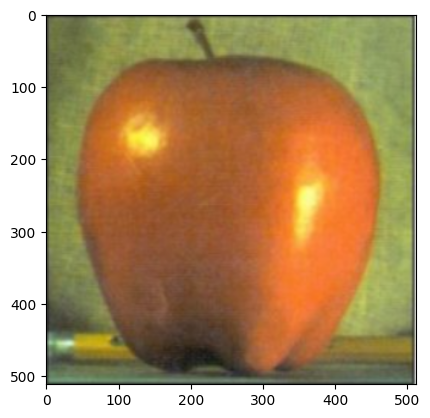

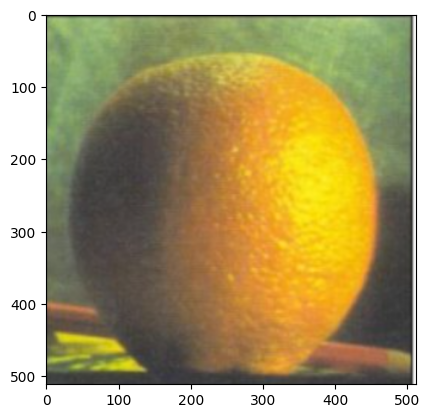

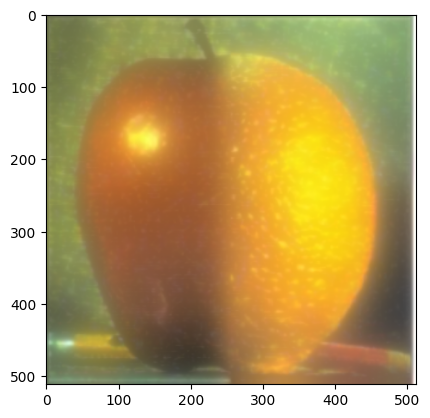

In [ ]:
A = cv.imread('apple.png')
B = cv.imread('orange.png')

# resize to the same size 512 for simplicity
A = cv.resize(A, (512, 512))
B = cv.resize(B, (512, 512))

plt.imshow(cv.cvtColor(A, cv.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv.cvtColor(B, cv.COLOR_BGR2RGB))
plt.show()

levels = 6

gaussian_pyramid_a = create_gaussian_pyramid(A, levels)
laplacian_pyramid_a = create_laplacian_pyramid(gaussian_pyramid_a)

gaussian_pyramid_b = create_gaussian_pyramid(B, levels)
laplacian_pyramid_b = create_laplacian_pyramid(gaussian_pyramid_b)

# Create Gaussian pyramid for the mask 
# take half of each image
mask = np.zeros_like(A)
mask[:, 0:A.shape[1] // 2] = 1 

gaussian_pyramid_mask = create_gaussian_pyramid(mask, levels)

# reverse mask lsit (biggest is at the end as laplacian pyramid)
gaussian_pyramid_mask = gaussian_pyramid_mask[::-1]

blended_pyramid = blend_pyramids(laplacian_pyramid_a, laplacian_pyramid_b, gaussian_pyramid_mask)

result = reconstruct_from_pyramid(blended_pyramid)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()	


Blend panorama

In [24]:

# Read images
A = cv.imread('im_left.jpg')
B = cv.imread('right.jpg')
A_shape = A.shape

# if one image is smaller, fill it with zeros
if A.shape[0] < B.shape[0]:
    A = np.concatenate((A, np.zeros((B.shape[0] - A.shape[0], A.shape[1], 3), dtype=np.uint8)), axis=0)
elif A.shape[0] > B.shape[0]:
    B = np.concatenate((B, np.zeros((A.shape[0] - B.shape[0], B.shape[1], 3), dtype=np.uint8)), axis=0)
print(A.shape, B.shape)

# also with width
if A.shape[1] < B.shape[1]:
    A = np.concatenate((A, np.zeros((A.shape[0], B.shape[1] - A.shape[1], 3), dtype=np.uint8)), axis=1)
elif A.shape[1] > B.shape[1]:
    B = np.concatenate((B, np.zeros((B.shape[0], A.shape[1] - B.shape[1], 3), dtype=np.uint8)), axis=1)
print(A.shape, B.shape)


#convert into right rgb 
plt.imshow(A)
plt.show()
plt.imshow(B)
plt.show()


# Number of pyramid levels
levels = 6

# Create Gaussian and Laplacian pyramids for A
gaussian_pyramid_a = create_gaussian_pyramid(A, levels)
laplacian_pyramid_a = create_laplacian_pyramid(gaussian_pyramid_a)

# Create Gaussian and Laplacian pyramids for B
gaussian_pyramid_b = create_gaussian_pyramid(B, levels)
laplacian_pyramid_b = create_laplacian_pyramid(gaussian_pyramid_b)

# Create Gaussian pyramid for the mask 
# mask is one where A is and zero where B is and -1 where none is

# find where zeros in image are
mask = np.zeros_like(A)
mask[np.where(A == 0)] = -1
mask[:A_shape[0], 0:A_shape[1]] = 1 
mask[:]

mask_gaussian_pyramid = create_gaussian_pyramid(mask, levels)

    
# Blend the Laplacian pyramids
blended_pyramid = blend_pyramids(laplacian_pyramid_a, laplacian_pyramid_b, mask_gaussian_pyramid[::-1])
img = reconstruct_from_pyramid(blended_pyramid)

plt.imshow(img)
plt.show()


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import torch
from models.matching import Matching

import torch
from spsgweights.superglue import SuperGlue
from spsgweights.superpoint import SuperPoint
import torch
import torch.nn as nn
import torch.nn.functional as F


class SPSG(nn.Module):  #
    def __init__(self,sp_model_path,sg_model_path,width=320,height=320,max_keypoint=100):
        super(SPSG, self).__init__()
        self.sp_model = SuperPoint(sp_model_path,max_keypoint)
        self.sg_model = SuperGlue(sg_model_path,width,height)

    def forward(self, x1, x2):
        keypoints1, scores1, descriptors1 = self.sp_model(x1)
        keypoints2, scores2, descriptors2 = self.sp_model(x2)
        # print(scores1.shape,keypoints1.shape,descriptors1.shape)
        # example=(descriptors1.unsqueeze(0),descriptors2.unsqueeze(0),keypoints1.unsqueeze(0),keypoints2.unsqueeze(0),scores1.unsqueeze(0),scores2.unsqueeze(0))
        example = (keypoints1, scores1,descriptors1, keypoints2, scores2, descriptors2)
        indices0, indices1, mscores0, mscores1 = self.sg_model(*example)
        # return indices0,  indices1,  mscores0,  mscores1
        matches = indices0[0]

        valid = torch.nonzero(matches > -1).squeeze().detach()
        mkpts0 = keypoints1[0].index_select(0, valid)
        mkpts1 = keypoints2[0].index_select(0, matches.index_select(0, valid))
        confidence = mscores0[0].index_select(0, valid)
        return mkpts0, mkpts1, confidence
    
# Initialize the model
config = {
        'superpoint': {
            'nms_radius': 4,
            'keypoint_threshold': 0.005,
            'max_keypoints': 1024
        },
        'superglue': {
            'weights': 'indoor',
            'sinkhorn_iterations': 20,
            'match_threshold': 0.2,
        }
    }

width=640
height=480


tensor1 = torch.rand(1,1,480, 640)
tensor2 = torch.rand(1,1,480, 640)


sp_model_path = "models/weights/superpoint_v1.pth"
sg_model_path = "models/weights/superglue_outdoor.pth"


model = SPSG(sp_model_path,sg_model_path,width,height)  
input_names = ["input1", "input2"]
output_names = ['mkpts0', 'mkpts1', 'confidence']
dummy_input = (tensor1, tensor2)
mkpts0_th, mkpts1_th, confidence_th = model(tensor1, tensor2)
ONNX_name = "sgsg.onnx"
torch.onnx.export(model.eval(), dummy_input, ONNX_name,
                    verbose=True,
                    input_names=input_names, opset_version=16,
                    dynamic_axes={
                        'input1': {2: 'image_height', 3: "image_width"},
                        'input2': {2: 'image_height', 3: "image_width"},
                    },
                    output_names=output_names) 

: 